In [76]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import math
import random
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import gym

In [195]:
def save_rewards_data(rewards_data, filename='rewards_data.pkl'):
    """Save the rewards data to a pickle file."""
    with open(filename, 'wb') as file:
        pickle.dump(rewards_data, file)
    print(f'Rewards data saved to {filename}')

def load_rewards_data(filename='rewards_data.pkl'):
    """Load the rewards data from a pickle file."""
    try:
        with open(filename, 'rb') as file:
            rewards_data = pickle.load(file)
        print(f'Rewards data loaded from {filename}')
        return rewards_data
    except FileNotFoundError:
        print(f'Error: The file {filename} does not exist. Please check the file path and try again.')
        return None
    except Exception as e:
        print(f'An error occurred while loading the data: {e}')
        return None


def reverse_keys(tc_data):
    """
    Reverse the keys of the tc_data dictionary.
    
    :param tc_data: Original dictionary with structure {alpha: {epsilon: data}}
    :return: New dictionary with structure {epsilon: {alpha: data}}
    """
    new_data = {}
    for alpha, epsilons in tc_data.items():
        for epsilon, data in epsilons.items():
            if epsilon not in new_data:
                new_data[epsilon] = {}
            new_data[epsilon][alpha] = data
    return new_data


def get_data_with_metadata(original_data, alpha, epsilon, algorithm_name):
    try:
        # Attempt to directly retrieve the data
        data = original_data[epsilon][alpha]
    except KeyError:
        # Return None if the specified alpha or epsilon does not exist
        data = None

    return {
        "algorithm_name": algorithm_name,
        "epsilon": epsilon,
        "alpha": alpha,
        "data": data
    }

def plot_rewards(rewards_data, algorithm_name="Expected SARSA", dec="TC", env="CartPole"):
    """Plot the average performance and IQR of the policy."""
    plt.figure(figsize=(14, 7))

    for epsilon, alphas in rewards_data.items():
        for alpha, data in alphas.items():
            # Calculate average and IQR across runs for each episode
            data = np.array(data)  # Convert to numpy array for easier slicing
            avg_rewards = np.mean(data, axis=0)
            lower_quartile = np.percentile(data, 25, axis=0)
            upper_quartile = np.percentile(data, 75, axis=0)

            episodes = np.arange(len(avg_rewards)) + 1
            plt.plot(episodes, avg_rewards, label=f'ε={epsilon}, α={alpha}')
            plt.fill_between(episodes, lower_quartile, upper_quartile, alpha=0.25)

    plt.title(f'Average Performance and IQR by Epsilon and Alpha ({algorithm_name} ({dec}) in {env})')
    plt.xlabel('Episodes')
    plt.ylabel('Average Reward')
    plt.legend()
    plt.show()


def calculate_cumulative_rewards(data_list):
    result_list = []

    for entry in data_list:
        algorithm_name = entry["algorithm_name"]
        alpha = entry["alpha"]
        epsilon = entry["epsilon"]
        episode_rewards = entry["data"]

        if episode_rewards is None or len(episode_rewards) == 0:
            cumulative_rewards = None
        else:
            # Convert to numpy array for easier mathematical operations
            data = np.array(episode_rewards)
            # Calculate the average rewards across all runs for each episode
            avg_rewards = np.mean(data, axis=0)
            # Calculate the cumulative sum of the average rewards
            cumulative_rewards = np.sum(avg_rewards)

        # Append the calculated data to the result list
        result_list.append({
            "algorithm_name": algorithm_name,
            "alpha": alpha,
            "epsilon": epsilon,
            "cumulative_rewards": cumulative_rewards.tolist() if cumulative_rewards is not None else None
        })

    return result_list


def plot_summary_performances(summary_data, title='Best Performance and IQR by Algorithm, Epsilon, and Alpha'):
    """
    Plot the average performance and IQR for the best data from different algorithms, 
    epsilon, and alpha.
    
    :param summary_data: A list of dictionaries, each containing algorithm name, 
                         epsilon, alpha, and data. The data should be in a format 
                         where each row represents a run, and each column an episode.
    """
    plt.figure(figsize=(14, 7))

    for entry in summary_data:
        algorithm_name = entry["algorithm_name"]
        epsilon = entry["epsilon"]
        alpha = entry["alpha"]
        data = np.array(entry["data"])  # Convert to numpy array for easier slicing

        if data.size > 0:  # Ensure there is data to process
            avg_rewards = np.mean(data, axis=0)
            lower_quartile = np.percentile(data, 25, axis=0)
            upper_quartile = np.percentile(data, 75, axis=0)

            episodes = np.arange(len(avg_rewards)) + 1
            plt.plot(episodes, avg_rewards, label=f'{algorithm_name}: ε={epsilon}, α={alpha}')
            plt.fill_between(episodes, lower_quartile, upper_quartile, alpha=0.25)

    plt.title(title)
    plt.xlabel('Episodes')
    plt.ylabel('Average Reward')
    plt.legend()
    plt.show()


def trim_rewards(rewards_data, episodes=500):
    # Trim each rewards list to the first 'episodes' entries
    for epsilon, alphas in rewards_data.items():
        for alpha, rewards_lists in alphas.items():
            trimmed_rewards_lists = [rewards_list[:episodes] for rewards_list in rewards_lists]
            rewards_data[epsilon][alpha] = trimmed_rewards_lists
            
    return rewards_data


## CarPole Expected SARSA

In [183]:
rbf_data = trim_rewards(load_rewards_data("Expected_SARSA_RBF/Expected_SARSA_RBF_CartPole"))
tc_data = trim_rewards(reverse_keys(load_rewards_data("Expected_SARSA_TC/CP/Results_ES_CP_TC_.pkl")))
four_data = reverse_keys(load_rewards_data("Expected_SARSA_Fourier/CP/Results_ES_CP_.pkl"))


Rewards data loaded from Expected_SARSA_RBF/Expected_SARSA_RBF_CartPole
Rewards data loaded from Expected_SARSA_TC/CP/Results_ES_CP_TC_.pkl
Rewards data loaded from Expected_SARSA_Fourier/CP/Results_ES_CP_.pkl


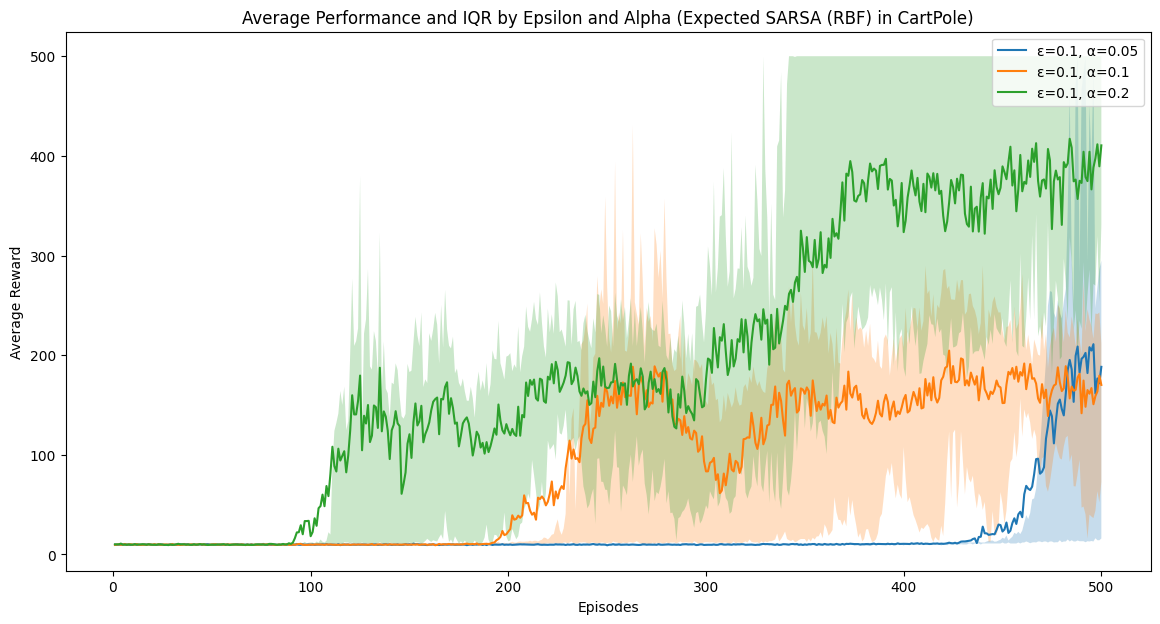

In [140]:
# RBF
plot_rewards(rbf_data, algorithm_name="Expected SARSA", dec="RBF", env="CartPole")

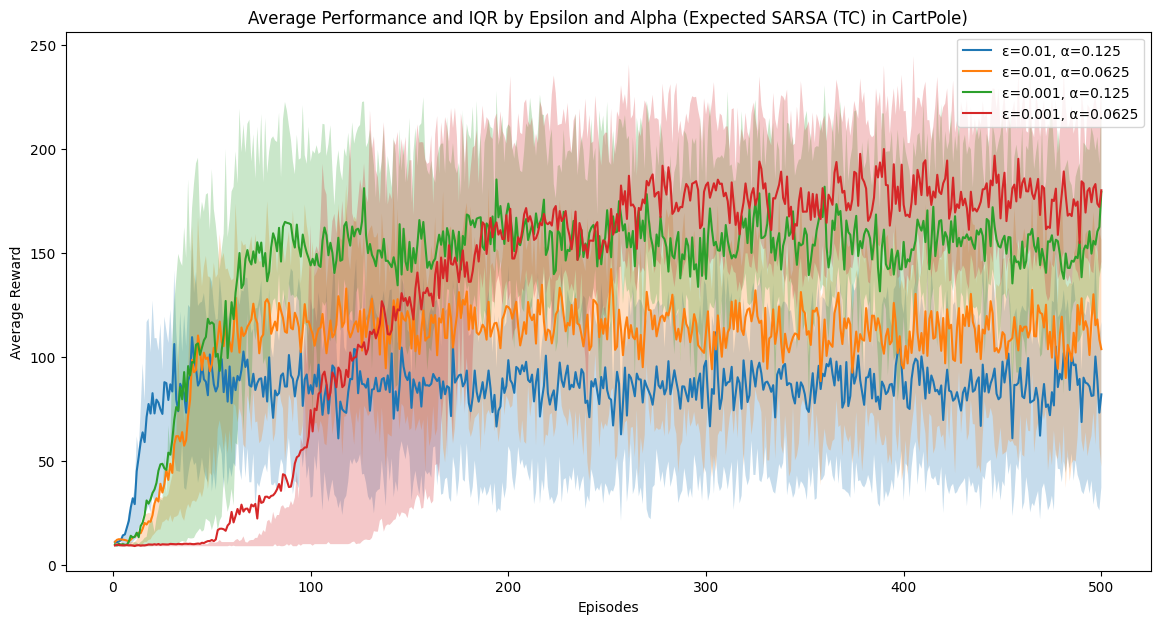

In [141]:
# TC
plot_rewards(tc_data, algorithm_name="Expected SARSA", dec="TC", env="CartPole")

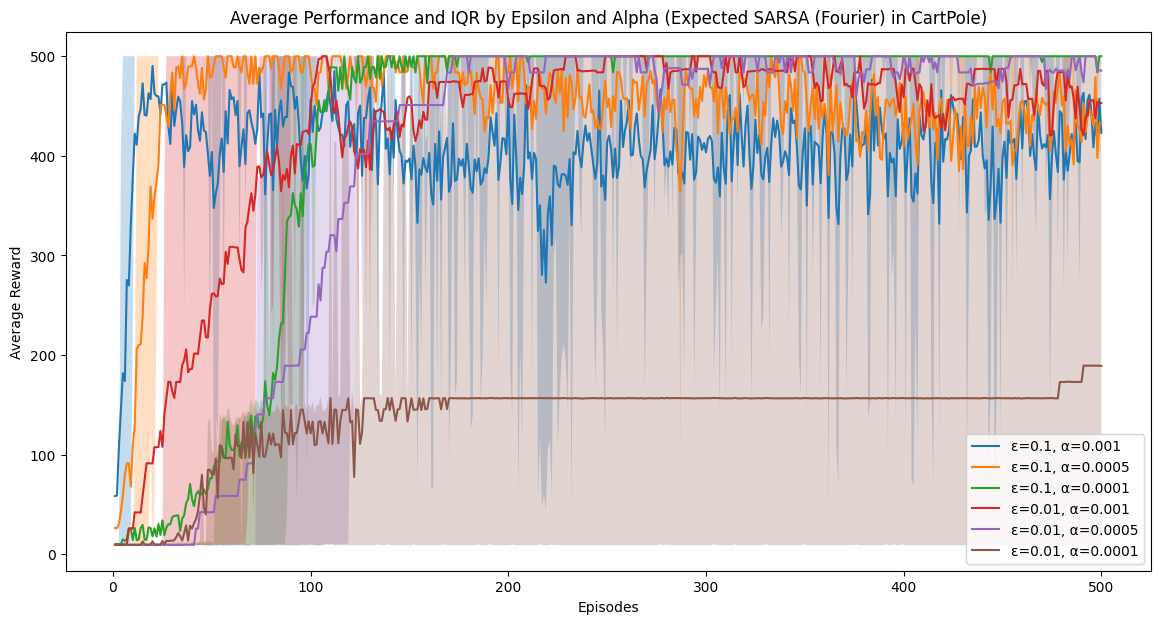

In [142]:
# Fourier
plot_rewards(four_data, algorithm_name="Expected SARSA", dec="Fourier", env="CartPole")

In [184]:
best_rbf = get_data_with_metadata(original_data=rbf_data, alpha=0.2, epsilon=0.1, algorithm_name="Expected SARSA (RBF)")
best_tc = get_data_with_metadata(original_data=tc_data, alpha=0.0625, epsilon=0.001, algorithm_name="Expected SARSA (Tile Coding)")
best_four = get_data_with_metadata(original_data=four_data, alpha=0.0001, epsilon=0.1, algorithm_name="Expected SARSA (Fourier Basis)")

summary = [
    best_rbf,
    best_tc,
    best_four
]

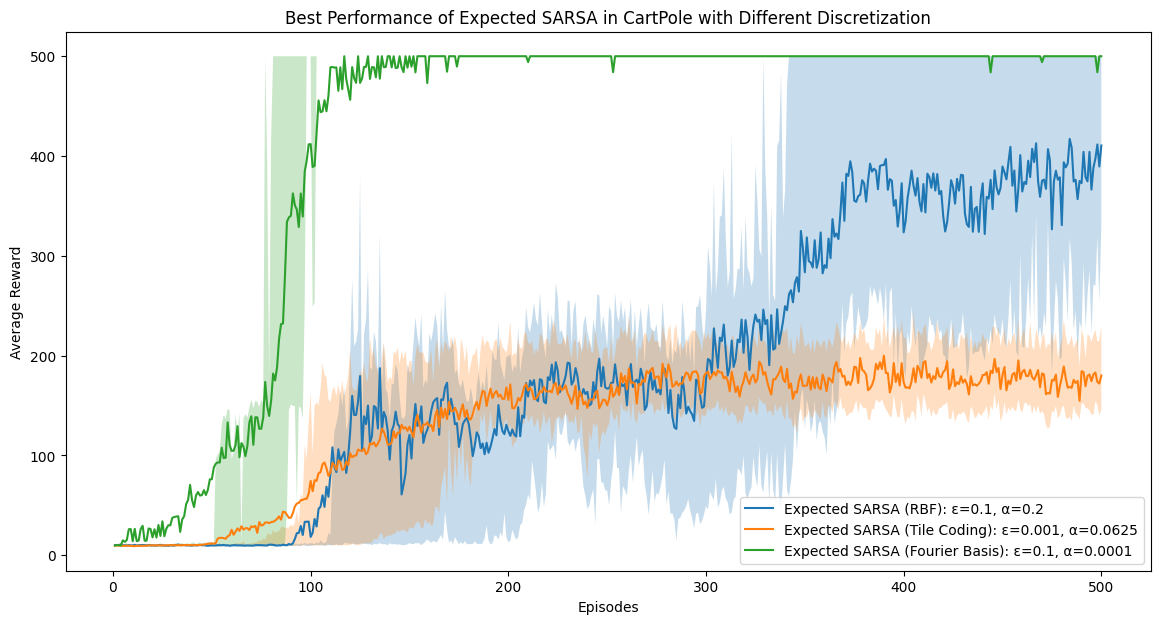

In [185]:
plot_summary_performances(summary, title='Best Performance of Expected SARSA in CartPole with Different Discretization')

In [91]:
# save Expected SARSA summary
save_rewards_data(summary, "CartPole_ES_Summary")

Rewards data saved to CartPole_ES_Summary


## CarPole DDQN

In [143]:
rbf_data = load_rewards_data("DDQN_RBF/DDQN_RBF_CP_combined.pkl")
tc_data = trim_rewards(load_rewards_data("DDQN_TC_Cheryl/DDQN_TC_CP.pkl"), episodes=200)
four_data = trim_rewards(load_rewards_data("DDQN_Fourier/DDQN_Fourier_CP.pkl"), episodes=200)

Rewards data loaded from DDQN_RBF/DDQN_RBF_CP_combined.pkl
Rewards data loaded from DDQN_TC_Cheryl/DDQN_TC_CP.pkl
Rewards data loaded from DDQN_Fourier/DDQN_Fourier_CP.pkl


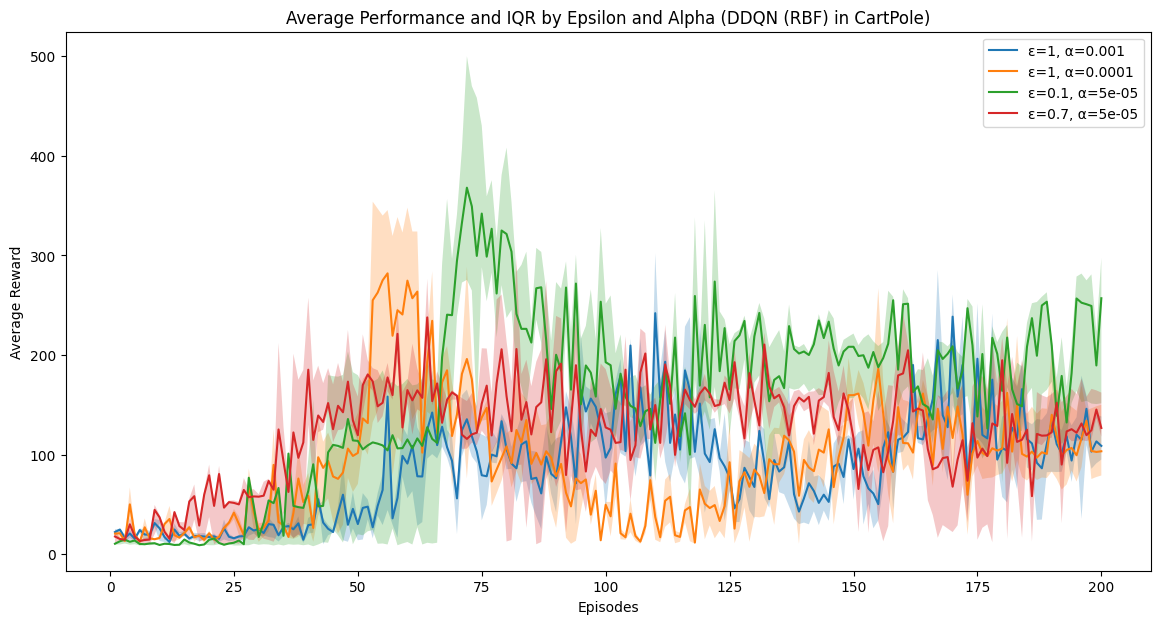

In [144]:
# RBF
plot_rewards(rbf_data, algorithm_name="DDQN", dec="RBF", env="CartPole")

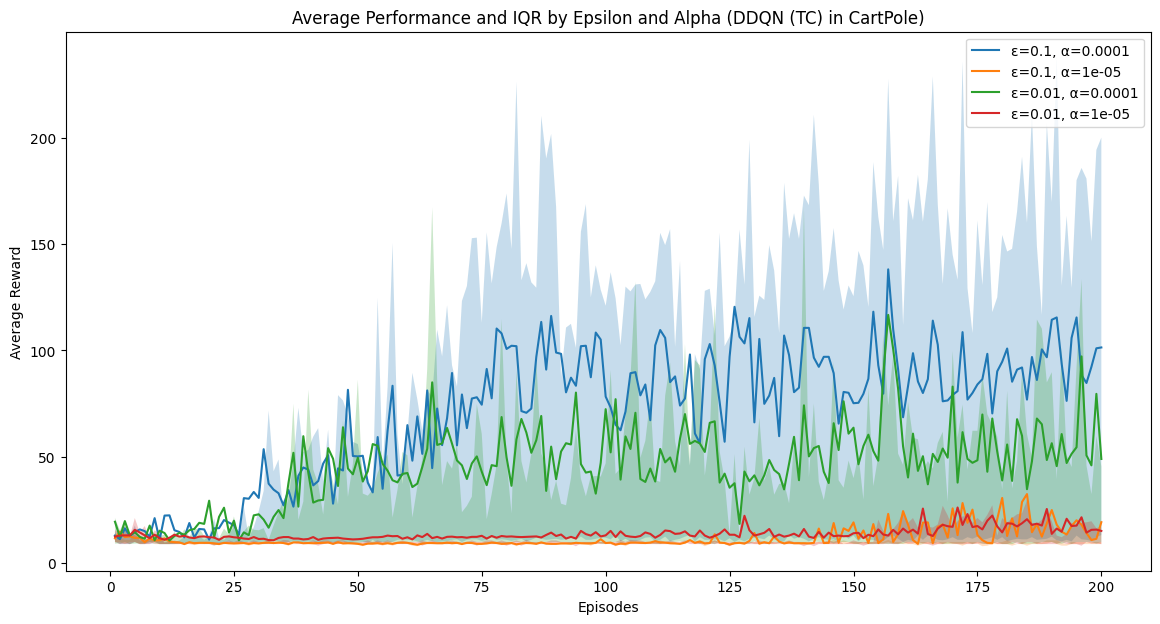

In [145]:
# TC
plot_rewards(tc_data, algorithm_name="DDQN", dec="TC", env="CartPole")

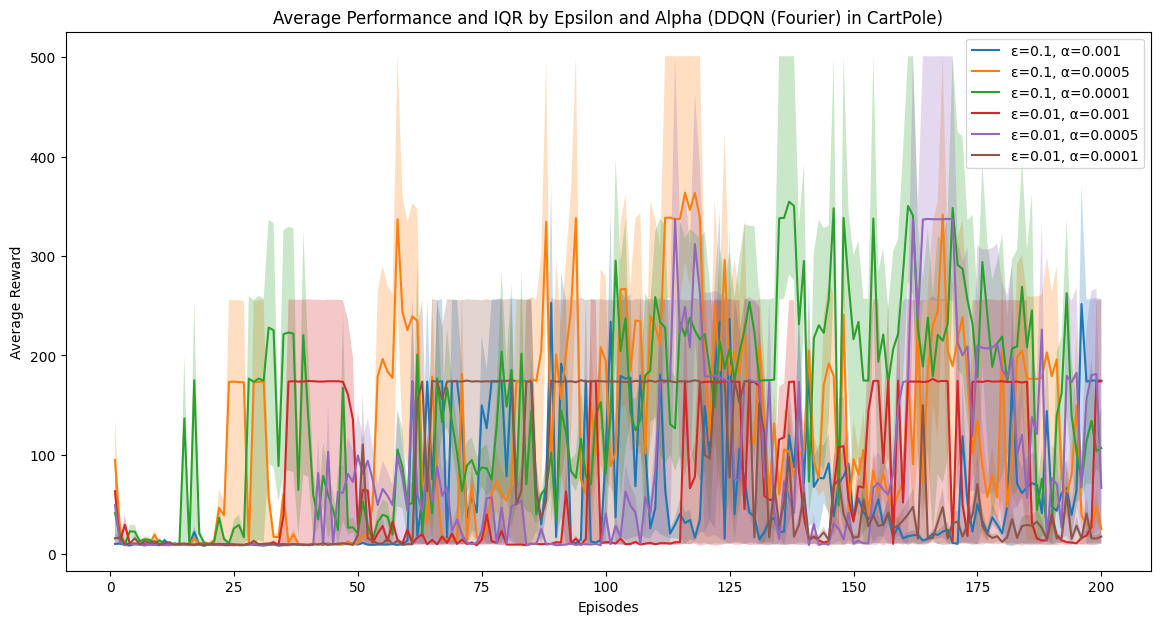

In [146]:
# Fourier
plot_rewards(four_data, algorithm_name="DDQN", dec="Fourier", env="CartPole")

In [108]:
best_rbf = get_data_with_metadata(original_data=rbf_data, alpha=5e-05, epsilon=0.1, algorithm_name="DDQN (RBF)")
best_tc = get_data_with_metadata(original_data=tc_data, alpha=0.0001, epsilon=0.01, algorithm_name="DDQN (Tile Coding)")
best_four = get_data_with_metadata(original_data=four_data, alpha=0.0005, epsilon=0.1, algorithm_name="DDQN (Fourier Basis)")

summary = [
    best_rbf,
    best_tc,
    best_four
]

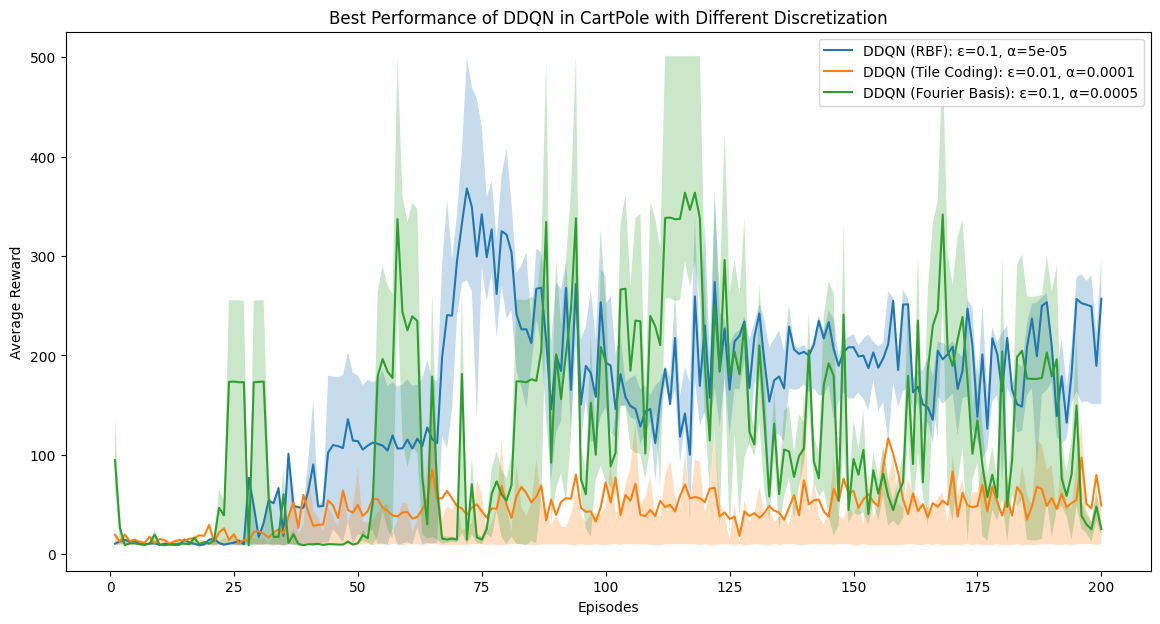

In [109]:
plot_summary_performances(summary, title='Best Performance of DDQN in CartPole with Different Discretization')

In [103]:
# save Expected SARSA summary
save_rewards_data(summary, "CartPole_DDQN_Summary")

Rewards data saved to CartPole_DDQN_Summary


## CarPole Combined


In [197]:
rbf_data = trim_rewards(load_rewards_data("Expected_SARSA_RBF/Expected_SARSA_RBF_CartPole"), episodes=200)
tc_data = trim_rewards(reverse_keys(load_rewards_data("Expected_SARSA_TC/CP/Results_ES_CP_TC_.pkl")), episodes=200)
four_data = trim_rewards(reverse_keys(load_rewards_data("Expected_SARSA_Fourier/CP/Results_ES_CP_.pkl")), episodes=200)
rbf_data_d = load_rewards_data("DDQN_RBF/DDQN_RBF_CP_combined.pkl")
tc_data_d = trim_rewards(load_rewards_data("DDQN_TC_Cheryl/DDQN_TC_CP.pkl"), episodes=200)
four_data_d = trim_rewards(load_rewards_data("DDQN_Fourier/DDQN_Fourier_CP.pkl"), episodes=200)

Rewards data loaded from Expected_SARSA_RBF/Expected_SARSA_RBF_CartPole
Rewards data loaded from Expected_SARSA_TC/CP/Results_ES_CP_TC_.pkl
Rewards data loaded from Expected_SARSA_Fourier/CP/Results_ES_CP_.pkl
Rewards data loaded from DDQN_RBF/DDQN_RBF_CP_combined.pkl
Rewards data loaded from DDQN_TC_Cheryl/DDQN_TC_CP.pkl
Rewards data loaded from DDQN_Fourier/DDQN_Fourier_CP.pkl


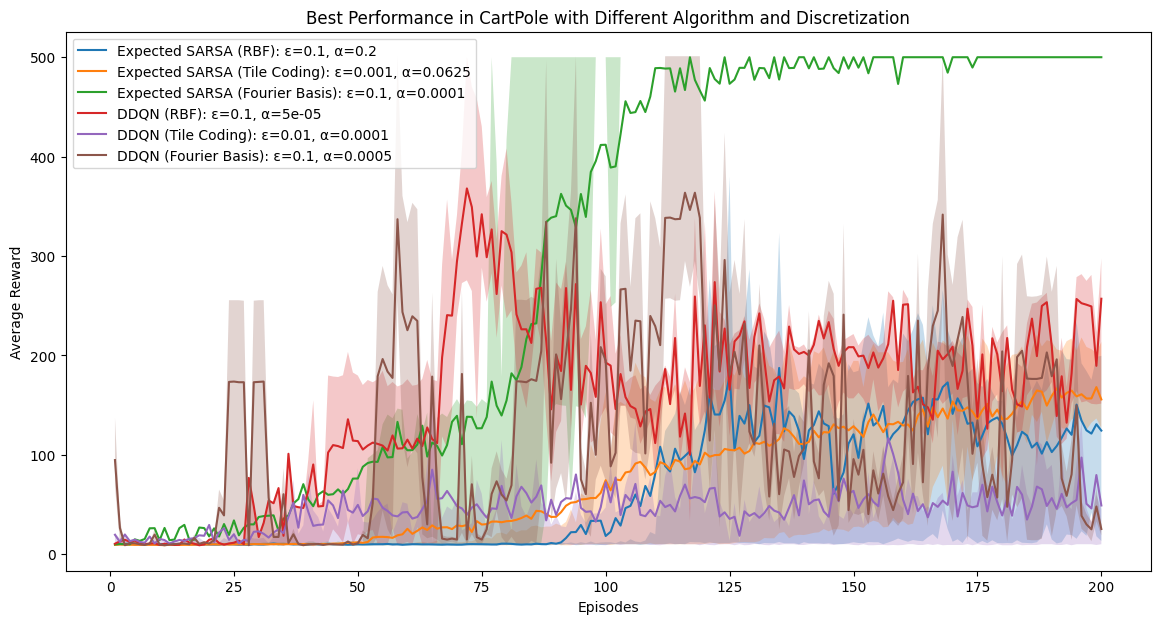

In [198]:
best_rbf = get_data_with_metadata(original_data=rbf_data, alpha=0.2, epsilon=0.1, algorithm_name="Expected SARSA (RBF)")
best_tc = get_data_with_metadata(original_data=tc_data, alpha=0.0625, epsilon=0.001, algorithm_name="Expected SARSA (Tile Coding)")
best_four = get_data_with_metadata(original_data=four_data, alpha=0.0001, epsilon=0.1, algorithm_name="Expected SARSA (Fourier Basis)")
best_rbf_d = get_data_with_metadata(original_data=rbf_data_d, alpha=5e-05, epsilon=0.1, algorithm_name="DDQN (RBF)")
best_tc_d = get_data_with_metadata(original_data=tc_data_d, alpha=0.0001, epsilon=0.01, algorithm_name="DDQN (Tile Coding)")
best_four_d = get_data_with_metadata(original_data=four_data_d, alpha=0.0005, epsilon=0.1, algorithm_name="DDQN (Fourier Basis)")

summary = [
    best_rbf,
    best_tc,
    best_four,
    best_rbf_d,
    best_tc_d,
    best_four_d
]

plot_summary_performances(summary, title='Best Performance in CartPole with Different Algorithm and Discretization')

In [199]:
cumulative = calculate_cumulative_rewards(summary)
cumulative

[{'algorithm_name': 'Expected SARSA (RBF)',
  'alpha': 0.2,
  'epsilon': 0.1,
  'cumulative_rewards': 13002.833333333334},
 {'algorithm_name': 'Expected SARSA (Tile Coding)',
  'alpha': 0.0625,
  'epsilon': 0.001,
  'cumulative_rewards': 14566.4},
 {'algorithm_name': 'Expected SARSA (Fourier Basis)',
  'alpha': 0.0001,
  'epsilon': 0.1,
  'cumulative_rewards': 60272.23333333334},
 {'algorithm_name': 'DDQN (RBF)',
  'alpha': 5e-05,
  'epsilon': 0.1,
  'cumulative_rewards': 31501.25},
 {'algorithm_name': 'DDQN (Tile Coding)',
  'alpha': 0.0001,
  'epsilon': 0.01,
  'cumulative_rewards': 9129.699999999999},
 {'algorithm_name': 'DDQN (Fourier Basis)',
  'alpha': 0.0005,
  'epsilon': 0.1,
  'cumulative_rewards': 24356.0}]

In [116]:
# save Expected SARSA summary
save_rewards_data(summary, "CartPole_Summary_200episodes")

Rewards data saved to CartPole_Summary_200episodes


## MountainCar Expected SARSA

In [159]:
rbf_data = load_rewards_data("Expected_SARSA_RBF/Expected_SARSA_RBF_MountainCar")
tc_data = reverse_keys(load_rewards_data("Expected_SARSA_TC/MC/Results_ES_MC_TC_2.pkl"))
four_data = reverse_keys(load_rewards_data("Expected_SARSA_Fourier/MC/Results_ES_MC_.pkl"))


Rewards data loaded from Expected_SARSA_RBF/Expected_SARSA_RBF_MountainCar
Rewards data loaded from Expected_SARSA_TC/MC/Results_ES_MC_TC_2.pkl
Rewards data loaded from Expected_SARSA_Fourier/MC/Results_ES_MC_.pkl


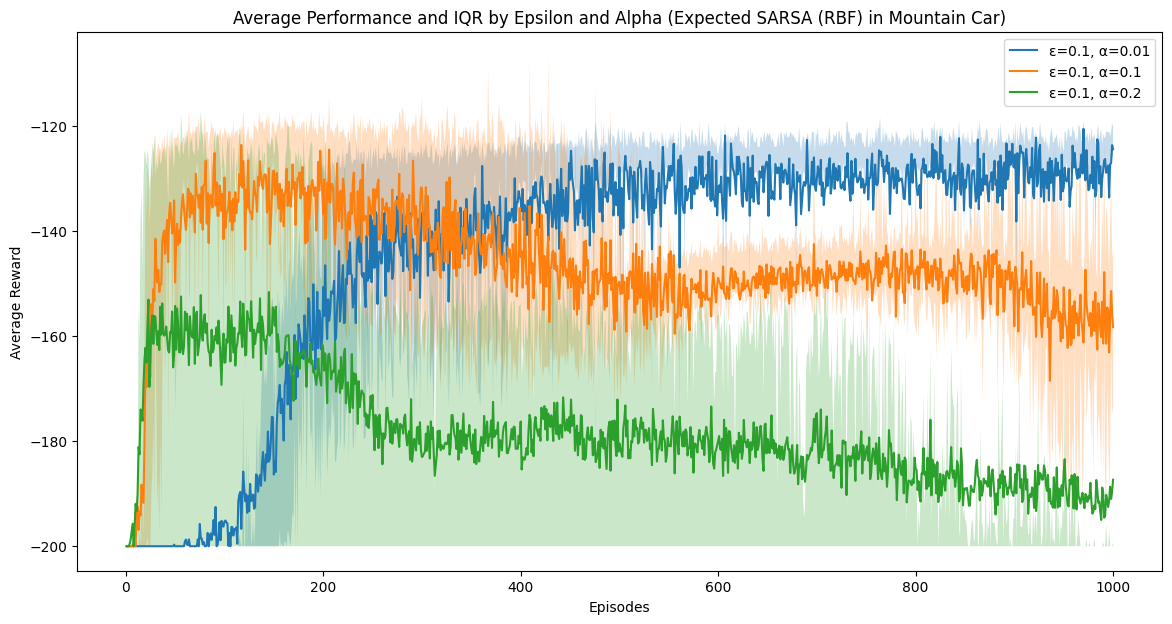

In [160]:
# RBF
plot_rewards(rbf_data, algorithm_name="Expected SARSA", dec="RBF", env="Mountain Car")

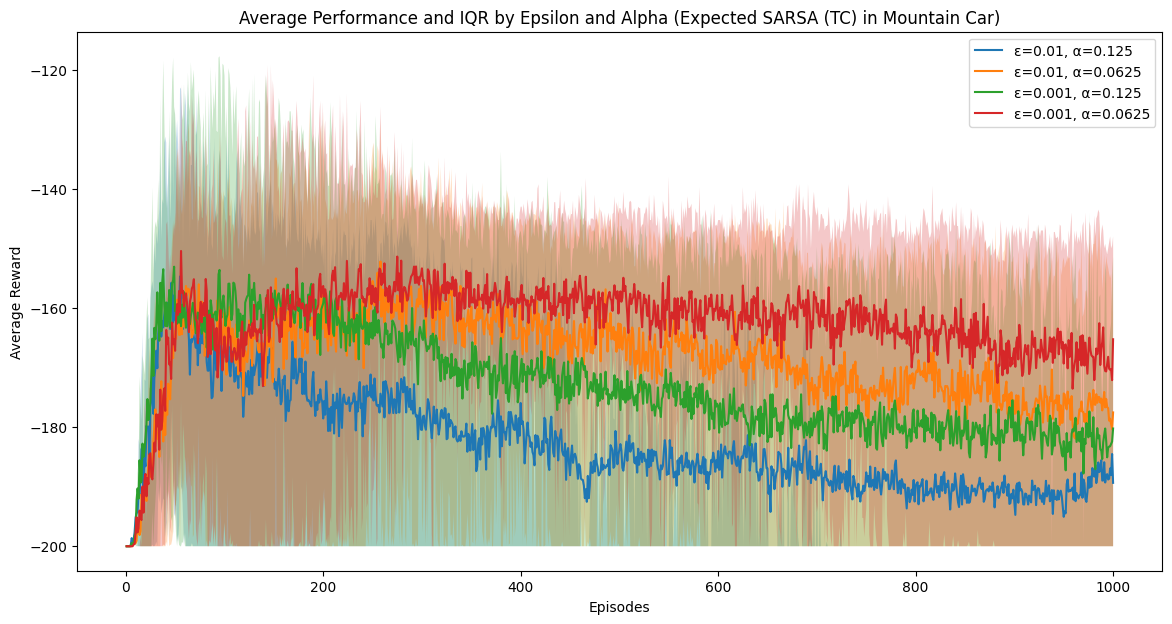

In [161]:
# TC
plot_rewards(tc_data, algorithm_name="Expected SARSA", dec="TC", env="Mountain Car")

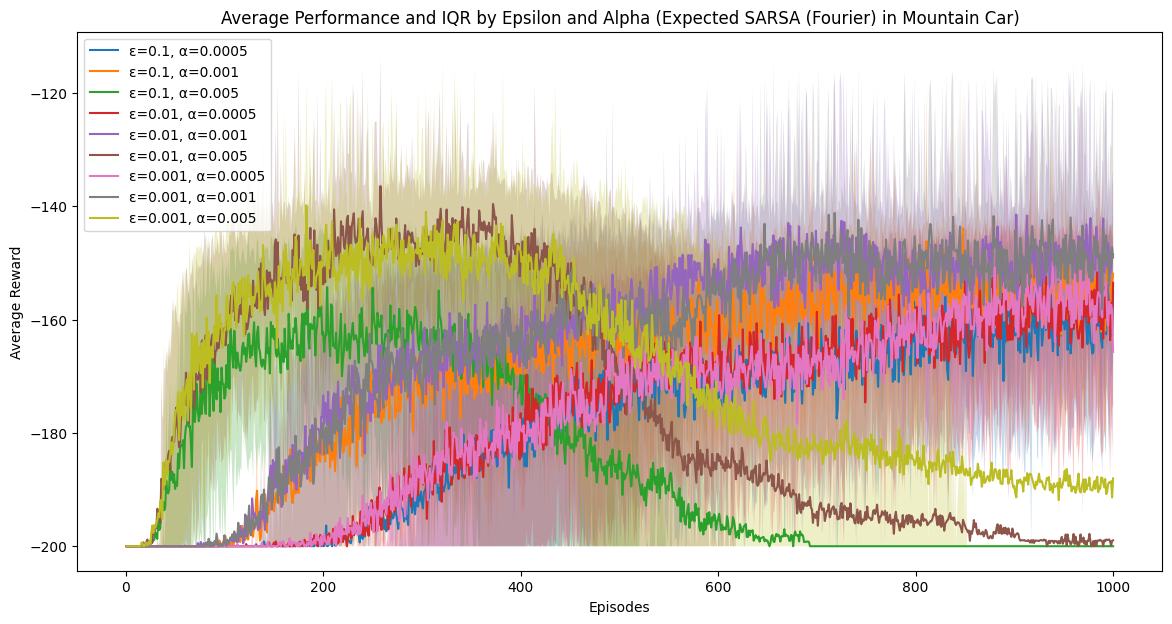

In [162]:
# Fourier
plot_rewards(four_data, algorithm_name="Expected SARSA", dec="Fourier", env="Mountain Car")

In [163]:
best_rbf = get_data_with_metadata(original_data=rbf_data, alpha=0.01, epsilon=0.1, algorithm_name="Expected SARSA (RBF)")
best_tc = get_data_with_metadata(original_data=tc_data, alpha=0.0625, epsilon=0.001, algorithm_name="Expected SARSA (Tile Coding)")
best_four = get_data_with_metadata(original_data=four_data, alpha=0.001, epsilon=0.001, algorithm_name="Expected SARSA (Fourier Basis)")

summary = [
    best_rbf,
    best_tc,
    best_four
]

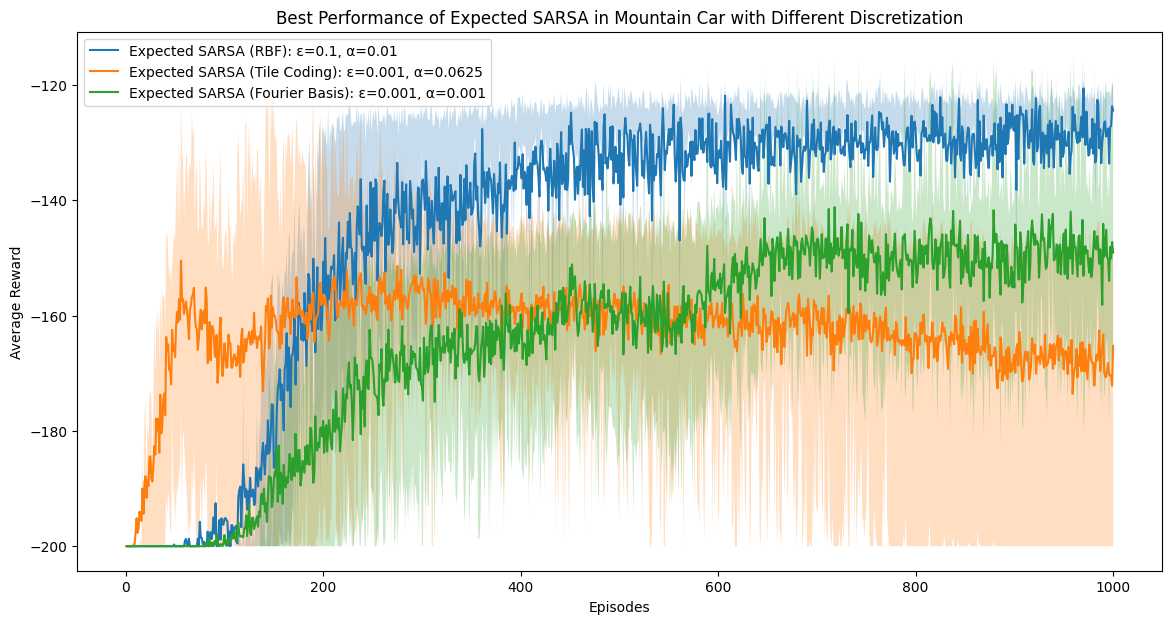

In [164]:
plot_summary_performances(summary, title='Best Performance of Expected SARSA in Mountain Car with Different Discretization')

In [165]:
# save Expected SARSA summary
save_rewards_data(summary, "MountainCar_ES_Summary")

Rewards data saved to MountainCar_ES_Summary


## MountainCar DDQN

In [172]:
rbf_data = load_rewards_data("DDQN_RBF/DDQN_RBF_MC_Combined.pkl")
tc_data = load_rewards_data("DDQN_TC_Cheryl/DDQN_TC_MC.pkl")
four_data = load_rewards_data("DDQN_Fourier/DDQN_Fourier_MC.pkl")

Rewards data loaded from DDQN_RBF/DDQN_RBF_MC_Combined.pkl
Rewards data loaded from DDQN_TC_Cheryl/DDQN_TC_MC.pkl
Rewards data loaded from DDQN_Fourier/DDQN_Fourier_MC.pkl


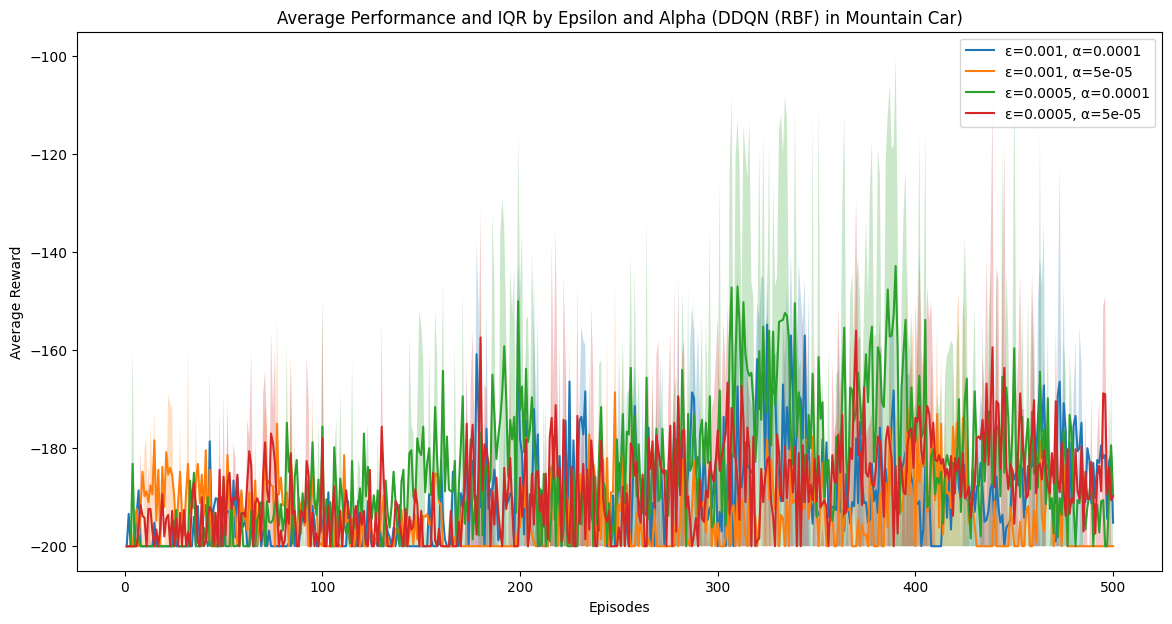

In [167]:
# RBF
plot_rewards(rbf_data, algorithm_name="DDQN", dec="RBF", env="Mountain Car")

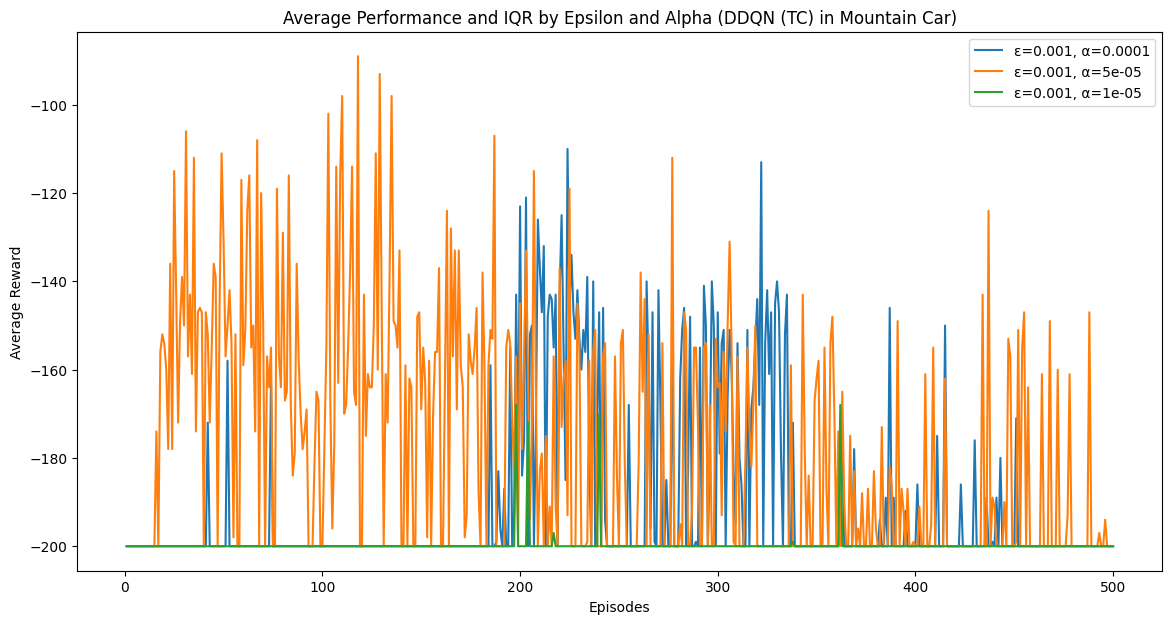

In [168]:
# TC
plot_rewards(tc_data, algorithm_name="DDQN", dec="TC", env="Mountain Car")

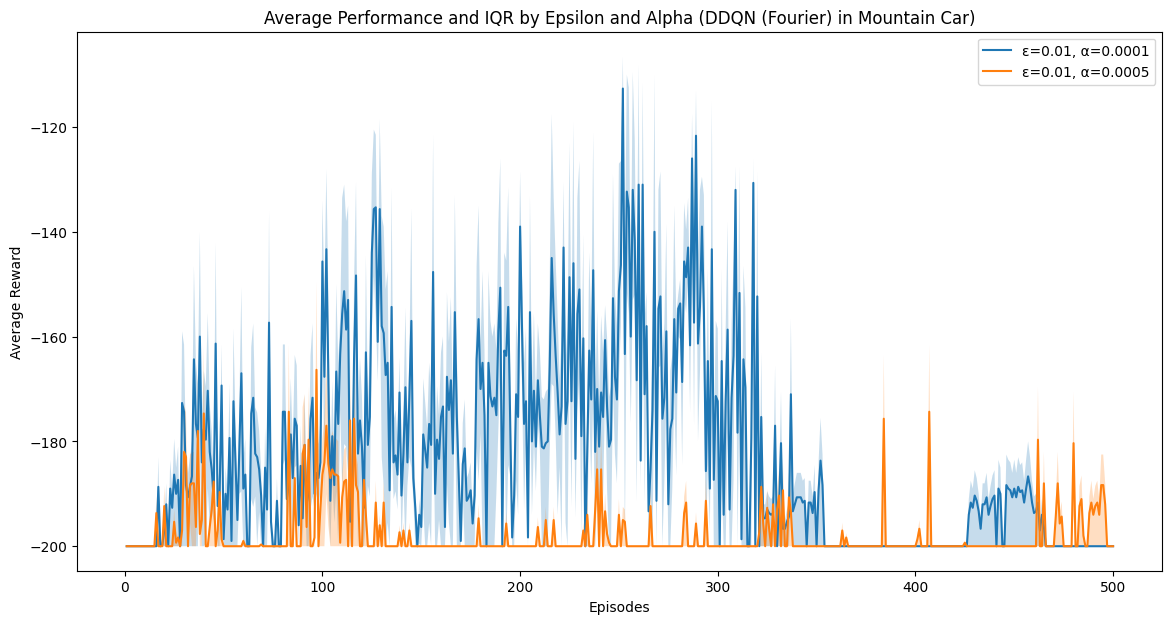

In [173]:
# Fourier
plot_rewards(four_data, algorithm_name="DDQN", dec="Fourier", env="Mountain Car")

In [174]:
best_rbf = get_data_with_metadata(original_data=rbf_data, alpha=0.0001, epsilon=0.0005, algorithm_name="DDQN (RBF)")
best_tc = get_data_with_metadata(original_data=tc_data, alpha=1e-4, epsilon=0.001, algorithm_name="DDQN (Tile Coding)")
best_four = get_data_with_metadata(original_data=four_data, alpha=0.0001, epsilon=0.01, algorithm_name="DDQN (Fourier Basis)")

summary = [
    best_rbf,
    best_tc,
    best_four
]

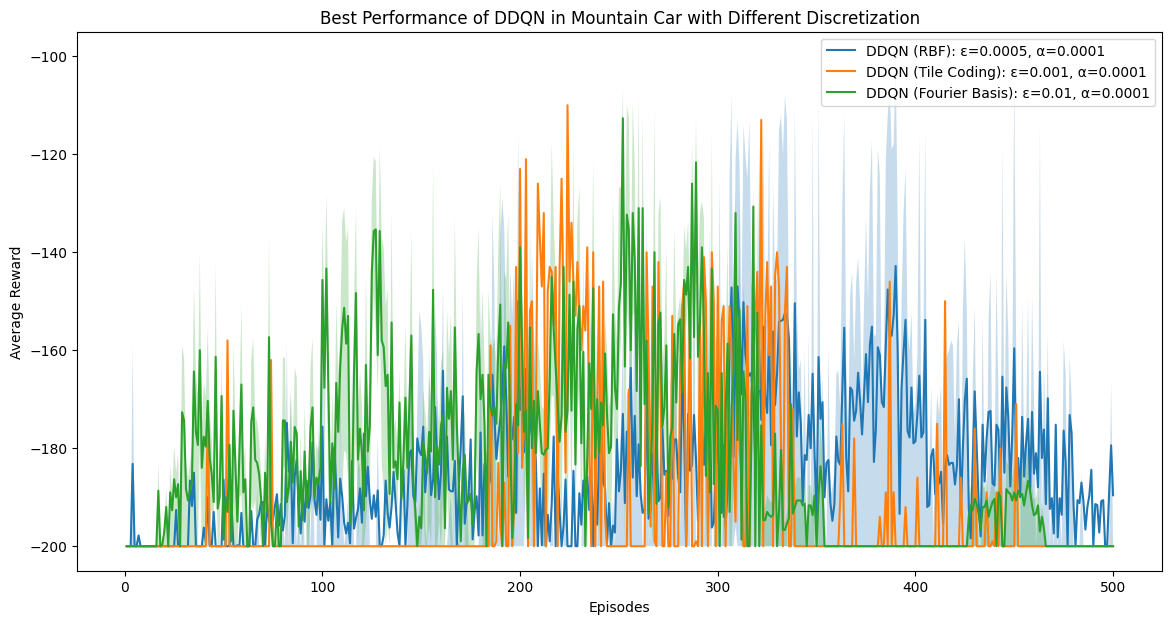

In [175]:
plot_summary_performances(summary, title='Best Performance of DDQN in Mountain Car with Different Discretization')


In [176]:
# save DDQN summary
save_rewards_data(summary, "MountainCar_DDQN_Summary")

Rewards data saved to MountainCar_DDQN_Summary


## MountainCar Combined

In [200]:
rbf_data = trim_rewards(load_rewards_data("Expected_SARSA_RBF/Expected_SARSA_RBF_MountainCar"), episodes=500)
tc_data = trim_rewards(reverse_keys(load_rewards_data("Expected_SARSA_TC/MC/Results_ES_MC_TC_2.pkl")), episodes=500)
four_data = trim_rewards(reverse_keys(load_rewards_data("Expected_SARSA_Fourier/MC/Results_ES_MC_.pkl")), episodes=500)
rbf_data_d = load_rewards_data("DDQN_RBF/DDQN_RBF_MC_Combined.pkl")
tc_data_d = load_rewards_data("DDQN_TC_Cheryl/DDQN_TC_MC.pkl")
four_data_d = load_rewards_data("DDQN_Fourier/DDQN_Fourier_MC.pkl")

best_rbf = get_data_with_metadata(original_data=rbf_data, alpha=0.01, epsilon=0.1, algorithm_name="Expected SARSA (RBF)")
best_tc = get_data_with_metadata(original_data=tc_data, alpha=0.0625, epsilon=0.001, algorithm_name="Expected SARSA (Tile Coding)")
best_four = get_data_with_metadata(original_data=four_data, alpha=0.001, epsilon=0.001, algorithm_name="Expected SARSA (Fourier Basis)")
best_rbf_d = get_data_with_metadata(original_data=rbf_data_d, alpha=0.0001, epsilon=0.0005, algorithm_name="DDQN (RBF)")
best_tc_d = get_data_with_metadata(original_data=tc_data_d, alpha=1e-4, epsilon=0.001, algorithm_name="DDQN (Tile Coding)")
best_four_d = get_data_with_metadata(original_data=four_data_d, alpha=0.0001, epsilon=0.01, algorithm_name="DDQN (Fourier Basis)")

summary = [
    best_rbf,
    best_tc,
    best_four,
    best_rbf_d,
    best_tc_d,
    best_four_d
]

Rewards data loaded from Expected_SARSA_RBF/Expected_SARSA_RBF_MountainCar
Rewards data loaded from Expected_SARSA_TC/MC/Results_ES_MC_TC_2.pkl
Rewards data loaded from Expected_SARSA_Fourier/MC/Results_ES_MC_.pkl
Rewards data loaded from DDQN_RBF/DDQN_RBF_MC_Combined.pkl
Rewards data loaded from DDQN_TC_Cheryl/DDQN_TC_MC.pkl
Rewards data loaded from DDQN_Fourier/DDQN_Fourier_MC.pkl


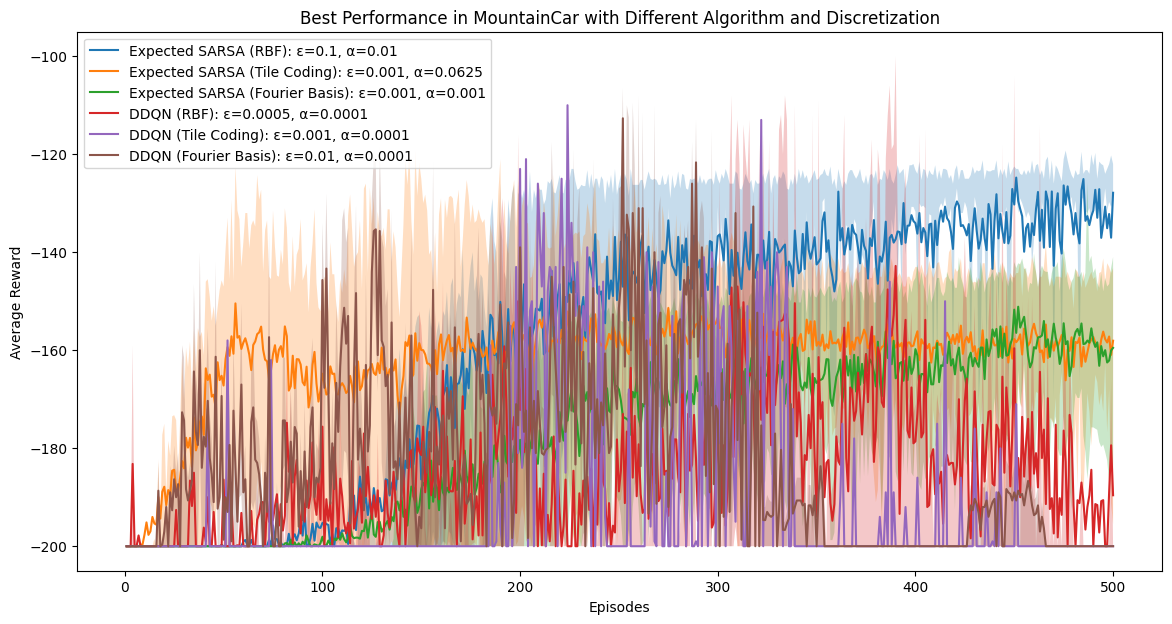

In [201]:
plot_summary_performances(summary, title='Best Performance in MountainCar with Different Algorithm and Discretization')

In [202]:
cumulative = calculate_cumulative_rewards(summary)
cumulative

[{'algorithm_name': 'Expected SARSA (RBF)',
  'alpha': 0.01,
  'epsilon': 0.1,
  'cumulative_rewards': -79667.83333333334},
 {'algorithm_name': 'Expected SARSA (Tile Coding)',
  'alpha': 0.0625,
  'epsilon': 0.001,
  'cumulative_rewards': -80910.70000000001},
 {'algorithm_name': 'Expected SARSA (Fourier Basis)',
  'alpha': 0.001,
  'epsilon': 0.001,
  'cumulative_rewards': -88779.36000000002},
 {'algorithm_name': 'DDQN (RBF)',
  'alpha': 0.0001,
  'epsilon': 0.0005,
  'cumulative_rewards': -92147.2},
 {'algorithm_name': 'DDQN (Tile Coding)',
  'alpha': 0.0001,
  'epsilon': 0.001,
  'cumulative_rewards': -95387.0},
 {'algorithm_name': 'DDQN (Fourier Basis)',
  'alpha': 0.0001,
  'epsilon': 0.01,
  'cumulative_rewards': -91428.0}]

In [180]:
# save Expected SARSA summary
save_rewards_data(summary, "MountainCar_Summary_500episodes")

Rewards data saved to MountainCar_Summary_500episodes
